## Homework

In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX' -O data.csv

--2022-02-19 07:31:11--  https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX
Resolving docs.google.com (docs.google.com)... 74.125.124.139, 74.125.124.100, 74.125.124.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.124.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/msvaed2k552t88j2dur5t8jfqv7rj89l/1645255800000/03856158561714992485/*/1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX?e=download [following]
--2022-02-19 07:31:13--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/msvaed2k552t88j2dur5t8jfqv7rj89l/1645255800000/03856158561714992485/*/1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX?e=download
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 74.125.70.132, 2607:f8b0:4001:c02::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googl

В этой домашней работе вы будете предсказывать стоимость домов по их характеристикам.

Метрика качества: `RMSE`

Оценивание:
* Baseline - 2 балла
* Feature Engineering - 2 балла
* Model Selection - 3 балла
* Ensemble v.1 - 3 балла
* (*) Ensemble v.2 - дополнительно, 2 балла

### Описание датасета

Короткое описание данных:
```
price: sale price (this is the target variable)
id: transaction id
timestamp: date of transaction
full_sq: total area in square meters, including loggias, balconies and other non-residential areas
life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
floor: for apartments, floor of the building
max_floor: number of floors in the building
material: wall material
build_year: year built
num_room: number of living rooms
kitch_sq: kitchen area
state: apartment condition
product_type: owner-occupier purchase or investment
sub_area: name of the district

The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes. See below for a complete list.

full_all: subarea population
male_f, female_f: subarea population by gender
young_*: population younger than working age
work_*: working-age population
ekder_*: retirement-age population
n_m_{all|male|female}: population between n and m years old
build_count_*: buildings in the subarea by construction type or year
x_count_500: the number of x within 500m of the property
x_part_500: the share of x within 500m of the property
_sqm_: square meters
cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
trc_: shopping malls
prom_: industrial zones
green_: green zones
metro_: subway
_avto_: distances by car
mkad_: Moscow Circle Auto Road
ttk_: Third Transport Ring
sadovoe_: Garden Ring
bulvar_ring_: Boulevard Ring
kremlin_: City center
zd_vokzaly_: Train station
oil_chemistry_: Dirty industry
ts_: Power plant
```

### Setup

In [158]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#ML algorithms
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost
import lightgbm

In [4]:
df = pd.read_csv("data.csv", parse_dates=["timestamp"])

Разделите имеющиеся у вас данные на обучающую и тестовую выборки. В качестве обучающей выборки возьмите первые 80% данных, последние 20% - тестовая выборка.

In [5]:
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price
0,0,2014-12-26,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,OwnerOccupier,Nagornoe,5.293465e+06,77878,0.023464,0.195781,4713,2279.0,4,5212,10027.0,8,1,NaN,3,0,2,2,no,0,2,6,no,no,no,no,no,no,no,...,705.32,1186.17,945.74,6,26,32,25,10,1,0,4,12,1,4,31,8,15.19,19.83,92,3478168,49,2235425,348,755.99,1263.47,1009.73,14,85,113,91,36,7,2,15,33,1,12,75,10,15318960
1,1,2012-10-04,64,64.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Poselenie Sosenskoe,6.677245e+07,9553,0.336177,0.072158,656,NaN,0,629,NaN,0,0,NaN,0,0,1,0,no,0,0,1,no,no,no,no,no,yes,no,...,1750.00,2875.00,2312.50,0,0,1,0,1,2,0,0,4,0,0,1,0,34.01,8.70,1,85159,1,189076,14,1108.33,1833.33,1470.83,2,1,4,3,2,2,0,0,13,1,0,6,1,6080000
2,2,2014-02-05,83,44.0,9.0,17.0,1.0,1985.0,3.0,10.0,3.0,Investment,Krylatskoe,1.216448e+07,78507,0.297166,0.000000,4611,3092.0,7,5067,7478.0,7,0,NaN,2,0,14,1,no,0,6,4,no,no,no,no,no,no,no,...,987.50,1645.83,1316.67,7,8,18,9,7,5,1,2,8,0,0,17,0,35.23,4.58,19,755824,19,1015107,95,923.26,1523.26,1223.26,9,18,25,23,13,6,1,8,18,0,1,52,0,17000000
3,3,2012-07-26,71,49.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Matushkino,4.708040e+06,38075,0.271702,0.310199,2448,2080.0,3,2748,3885.0,4,0,NaN,0,0,0,0,no,0,0,1,no,no,no,no,no,no,no,...,500.00,850.00,675.00,0,5,3,2,0,0,0,1,2,0,1,4,1,20.84,7.28,3,51038,7,49700,14,507.14,857.14,682.14,0,7,4,3,0,0,0,1,3,0,2,8,2,990000
4,4,2014-10-29,60,42.0,9.0,9.0,1.0,1970.0,3.0,6.0,2.0,Investment,Gol'janovo,1.428699e+07,157010,0.389354,0.194489,7751,5041.0,6,8004,11081.0,7,0,125.0,3,0,5,3,no,0,5,3,no,no,no,yes,no,no,no,...,608.33,1020.83,814.58,2,7,9,8,0,0,0,3,3,0,0,13,2,36.40,9.08,11,300476,16,509176,54,656.00,1110.00,883.00,4,16,18,12,3,1,0,5,8,0,1,34,5,7900000


In [6]:
X = df.drop(columns='price')
y = df['price']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_TRAIN = X_train.copy() # сохраним исходные данные
X_TEST = X_test.copy()

Возможно в ваших моделях вам придется указывать, какие колонки являются категориальными (например, в бустингах). Для упрощения предлагается разделить колонки по следующему принципу:
```
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]
cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]
num_columns = list(set(df.columns).difference(set(cat_columns + drop_columns)))
```

In [8]:
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]
cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]
num_columns = list(set(X_train.columns).difference(set(cat_columns + drop_columns)))

### Baseline (2 балла)

В качестве Baseline обучите `DecisionTreeRegressor` из `sklearn`.

### Preparing dataset: пропуски

In [9]:
print(X.shape)

(20000, 291)


In [10]:
X.isna().any().sum(axis = 0) #  сколько признаков содержат неизвестные значения

51

In [11]:
X.isna().sum().sort_values(ascending=False)[:51]

hospital_beds_raion                      9404
state                                    8907
build_year                               8905
cafe_avg_price_500                       8778
cafe_sum_500_max_price_avg               8778
cafe_sum_500_min_price_avg               8778
max_floor                                6303
material                                 6303
num_room                                 6303
kitch_sq                                 6303
cafe_sum_1000_max_price_avg              4285
cafe_avg_price_1000                      4285
cafe_sum_1000_min_price_avg              4285
preschool_quota                          4279
school_quota                             4277
life_sq                                  4103
build_count_foam                         3175
build_count_wood                         3175
build_count_frame                        3175
build_count_brick                        3175
build_count_monolith                     3175
build_count_panel                 

In [12]:
columns_nan = X.isna().sum().sort_values(ascending=False)[:51].index

In [13]:
cols_nan_num = set(columns_nan) & set(num_columns)

In [14]:
print(len(cols_nan_num)) # пропуски в числовых признаках

48


In [15]:
cols_nan_cat = set(columns_nan) & set(cat_columns)

In [16]:
print(len(cols_nan_cat)) # пропуски в категорилаьных признаках

3


In [17]:
X_train_num = X_train[cols_nan_num]

In [18]:
# разобьем данные на группы и в каждой группе заполним средним все числовые пропуски
kf = KFold(n_splits=5)
for other, idxs in kf.split(X_train_num):
    selection = X_train_num.iloc[idxs] # берем часть данных
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean') # стратегия заполнения
    clean = pd.DataFrame(imp_mean.fit_transform(selection), columns = selection.columns) # запоминаем очищенную выборку
    X_train_num.iloc[idxs] = clean

In [19]:
X_train[list(cols_nan_num)] = X_train_num # исправляем числовые пропуски в трейне

In [20]:
X_train.isna().any().sum(axis=0) # осталось три категориальных признака с NaN

3

In [21]:
X_train_cat = X_train[cols_nan_cat]

In [22]:
kf = KFold(n_splits=5)
for other, idxs in kf.split(X_train_cat): # заполним пропуски для категориальных данных
    selection = X_train_cat.iloc[idxs] # берем часть данных
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent') # стратегия заполнения
    clean = pd.DataFrame(imp_mean.fit_transform(selection), columns = selection.columns) # запоминаем очищенную выборку
    X_train_cat.iloc[idxs] = clean

In [23]:
X_train[list(cols_nan_cat)] =  X_train_cat

In [24]:
X_train.isna().any().sum().sum()

0

In [25]:
# убираем все категориальные признаки
Xcat = X_train[cat_columns]
X_train.drop(columns = cat_columns, inplace=True)

In [26]:
X_cat = pd.get_dummies(Xcat)
print(Xcat.shape) # было
print(X_cat.shape) # one-hot encoding стало

(16000, 24)
(16000, 186)


In [27]:
X_train = pd.concat([X_train, X_cat], axis = 1)
X_train.drop(columns = drop_columns, inplace=True)

In [28]:
print(X_train.shape)

(16000, 451)


### Сделаем тоже самое для тестовой выборки. Мемори лики будут отсутствовать.

In [29]:
# разобьем данные на группы и в каждой группе заполним средним все числовые пропуски
X_test_num = X_test[cols_nan_num]
kf = KFold(n_splits=5)
for other, idxs in kf.split(X_test_num):
    selection = X_test_num.iloc[idxs] # берем часть данных
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean') # стратегия заполнения
    clean = pd.DataFrame(imp_mean.fit_transform(selection), columns = selection.columns) # запоминаем очищенную выборку
    X_test_num.iloc[idxs] = clean
X_test[list(cols_nan_num)] = X_test_num # исправляем числовые пропуски в тесте

X_test_cat = X_test[cols_nan_cat]
kf = KFold(n_splits=5)
for other, idxs in kf.split(X_test_cat): # заполним пропуски для категориальных данных
    selection = X_test_cat.iloc[idxs] # берем часть данных
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent') # стратегия заполнения
    clean = pd.DataFrame(imp_mean.fit_transform(selection), columns = selection.columns) # запоминаем очищенную выборку
    X_test_cat.iloc[idxs] = clean
X_test[list(cols_nan_cat)] =  X_test_cat # исправляем числовые пропуски в тесте
print(X_test.isna().any().sum().sum()) # должно остаться ноль пропусков

# убираем все категориальные признаки
Xcat = X_test[cat_columns]
X_test.drop(columns = cat_columns, inplace=True)
X_cat = pd.get_dummies(Xcat)
X_test = pd.concat([X_test, X_cat], axis = 1)

X_test.drop(columns = drop_columns, inplace=True) # убираем ненужные признаки

0


### Бейзлайн - линейная регрессия

In [30]:
res = set(X_train.columns) - set(X_test.columns)
res # те колонки, которых нет в тестовой выбрке

{'sub_area_Molzhaninovskoe',
 'sub_area_Poselenie Kievskij',
 'sub_area_Poselenie Klenovskoe',
 'sub_area_Poselenie Mihajlovo-Jarcevskoe',
 'sub_area_Poselenie Shhapovskoe',
 'sub_area_Poselenie Voronovskoe',
 'sub_area_Vostochnoe'}

In [31]:
X_test[list(res)] = np.zeros((X_test.shape[0], len(res)))

In [32]:
res = set(X_test.columns) - set(X_train.columns)
res # те колонки, которых нет в трейне

set()

In [33]:
X_train[list(res)] = np.zeros((X_train.shape[0], len(res)))

In [34]:
print(X_test.shape) # теперь shape у трейна и теста должен быть одинаковым
print(X_train.shape)

(4000, 451)
(16000, 451)


In [35]:
# расположим колонки в тесте в таком же порядке, как в трейне
X_test = X_test.reindex(columns=X_train.columns)

In [36]:
def RMSE(y_test, y_pred):
    return mean_squared_error(y_test, y_pred, squared=False)

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(RMSE(y_test, y_pred))

3222702.329998895


### Обучение Decision Tree

In [38]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [39]:
y_pred = clf.predict(X_test)
print(RMSE(y_test, y_pred))

3919562.231522684


### Нормализация признаков

In [40]:
X_train

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,...,sub_area_Veshnjaki,sub_area_Vnukovo,sub_area_Vojkovskoe,sub_area_Vostochnoe,sub_area_Vostochnoe Degunino,sub_area_Vostochnoe Izmajlovo,sub_area_Vyhino-Zhulebino,sub_area_Zamoskvorech'e,sub_area_Zapadnoe Degunino,sub_area_Zjablikovo,sub_area_Zjuzino,culture_objects_top_25_no,culture_objects_top_25_yes,thermal_power_plant_raion_no,thermal_power_plant_raion_yes,incineration_raion_no,incineration_raion_yes,oil_chemistry_raion_no,oil_chemistry_raion_yes,radiation_raion_no,radiation_raion_yes,railroad_terminal_raion_no,railroad_terminal_raion_yes,big_market_raion_no,big_market_raion_yes,nuclear_reactor_raion_no,nuclear_reactor_raion_yes,detention_facility_raion_no,detention_facility_raion_yes,water_1line_no,water_1line_yes,big_road1_1line_no,big_road1_1line_yes,railroad_1line_no,railroad_1line_yes,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
5894,96,96.000000,3.0,12.759690,1869.313165,1.914273,6.865937,7.307411e+06,75377,0.065444,0.000078,4237,1874.000000,4,6398,6772.000000,4,1,1046.000000,3,2,29,16,10,23,141,116742,52836,63906,11272,5470,5802,43921,21901,22020,20184,6644,13540,4237,2079,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0
3728,64,33.000000,2.0,17.000000,2014.000000,2.000000,12.000000,3.879802e+06,81980,0.157332,0.232205,4926,2200.000000,4,4860,6476.000000,4,1,80.000000,0,0,4,2,0,3,1,27992,12961,15031,10412,5439,4973,52793,26701,26092,18775,5743,13032,4926,2565,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0
8958,73,34.277756,17.0,17.000000,1869.313165,2.000000,1.000000,1.139168e+07,19940,0.055644,0.243205,1706,2395.000000,5,1564,7377.000000,5,0,540.000000,0,0,0,4,0,0,0,247469,112902,134567,3459,1782,1677,13331,6670,6661,3150,948,2202,1706,862,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0
7671,60,34.277756,4.0,18.000000,1.000000,2.000000,1.000000,1.084231e+07,85219,0.062172,0.161532,5767,5278.000000,6,5648,10529.000000,6,0,30.000000,2,0,4,1,0,4,1,221709,101426,120283,12194,6155,6039,58114,28761,29353,14911,4222,10689,5767,2919,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0
5999,40,34.277756,9.0,12.759690,1869.313165,1.914273,6.865937,1.139168e+07,19940,0.055644,0.243205,1706,2395.000000,5,1564,7377.000000,5,0,540.000000,0,0,0,4,0,0,0,247469,112902,134567,3459,1782,1677,13331,6670,6661,3150,948,2202,1706,862,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,46,28.000000,4.0,12.000000,1972.000000,2.000000,9.000000,8.087656e+06,116742,0.048011,0.007659,6694,3318.000000,5,7077,9748.000000,10,0,2301.000000,3,1,24,1,1,19,56,123280,57224,66056,14715,7597,7118,71253,35672,35581,30774,9567,21207,6694,3466,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0
11964,46,46.000000,10.0,12.429025,1879.667040,1.883447,5.908844,6.677245e+07,9553,0.336177,0.072158,656,3306.036364,0,629,8328.763636,0,0,1200.324667,0,0,1,0,0,0,1,13890,6584,7307,1370,709,661,6127,3237,2890,2056,58

In [41]:
std = StandardScaler()
std.fit(X_train[num_columns])
X_train_norm = X_train.copy()
X_train_norm[num_columns] = std.transform(X_train[num_columns])

In [42]:
X_train_norm = pd.DataFrame(X_train_norm)
X_train_norm

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,...,sub_area_Veshnjaki,sub_area_Vnukovo,sub_area_Vojkovskoe,sub_area_Vostochnoe,sub_area_Vostochnoe Degunino,sub_area_Vostochnoe Izmajlovo,sub_area_Vyhino-Zhulebino,sub_area_Zamoskvorech'e,sub_area_Zapadnoe Degunino,sub_area_Zjablikovo,sub_area_Zjuzino,culture_objects_top_25_no,culture_objects_top_25_yes,thermal_power_plant_raion_no,thermal_power_plant_raion_yes,incineration_raion_no,incineration_raion_yes,oil_chemistry_raion_no,oil_chemistry_raion_yes,radiation_raion_no,radiation_raion_yes,railroad_terminal_raion_no,railroad_terminal_raion_yes,big_market_raion_no,big_market_raion_yes,nuclear_reactor_raion_no,nuclear_reactor_raion_yes,detention_facility_raion_no,detention_facility_raion_yes,water_1line_no,water_1line_yes,big_road1_1line_no,big_road1_1line_yes,railroad_1line_no,railroad_1line_yes,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
5894,0.876474,3.303707,-0.881160,0.023950,-0.014701,0.013531,0.010672,-0.493396,-0.157809,-0.875787,-0.998936,-0.243260,-0.733128,-0.028627,0.255336,-0.410886,-0.211393,2.664646,-0.190733,1.126597,4.200225,3.391975,3.964832,6.335651,3.931943,5.603774,-0.108992,-0.115512,-0.103470,0.004835,-0.065760,0.079915,-0.267853,-0.291055,-0.242816,0.065664,0.195514,0.007480,-0.243260,-0.286365,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0
3728,0.204198,-0.063847,-1.070905,0.786055,-0.013789,0.137529,0.193906,-0.658102,-0.043610,-0.353380,0.953026,-0.062537,-0.562967,-0.028627,-0.130546,-0.488928,-0.211393,2.664646,-1.446110,-0.885184,-0.313416,-0.406365,-0.278953,-0.190397,-0.260453,-0.306701,-0.420745,-0.421913,-0.419626,-0.099042,-0.073017,-0.126548,-0.030924,-0.037435,-0.024144,-0.041247,-0.025541,-0.048055,-0.062537,-0.039841,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0
8958,0.393276,0.004453,1.775269,0.786055,-0.014701,0.137529,-0.198682,-0.297134,-1.116587,-0.931507,1.045520,-0.907133,-0.461183,0.305707,-0.957509,-0.251375,0.079281,-0.333128,-0.848312,-0.885184,-0.313416,-1.014100,0.327302,-0.190397,-0.889312,-0.348919,0.350214,0.346039,0.353613,-0.938883,-0.929125,-0.947415,-1.084763,-1.095825,-1.067616,-1.226833,-1.201970,-1.232007,-0.907133,-0.903690,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0
7671,0.120164,0.004453,-0.691415,0.965783,-0.026486,0.137529,-0.198682,-0.323533,0.012408,-0.894389,0.358732,0.158055,1.043649,0.640042,0.067162,0.579669,0.369956,-0.333128,-1.511088,0.456004,-0.313416,-0.406365,-0.582081,-0.190397,-0.050833,-0.306701,0.259727,0.257856,0.261214,0.116202,0.094599,0.138939,0.111174,0.071410,0.150977,-0.334438,-0.398711,-0.304195,0.158055,0.139726,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0
5999,-0.300008,0.004453,0.257310,0.023950,-0.014701,0.013531,0.010672,-0.297134,-1.116587,-0.931507,1.045520,-0.907133,-0.461183,0.305707,-0.957509,-0.251375,0.079281,-0.333128,-0.848312,-0.885184,-0.313416,-1.014100,0.327302,-0.190397,-0.889312,-0.348919,0.350214,0.346039,0.353613,-0.938883,-0.929125,-0.947415,-1.084763,-1.095825,-1.067616,-1.226833,-1.201970,-1.232007,-0.907133,-0.903690,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [43]:
X_test_norm = X_test.copy()
X_test_norm[num_columns] = std.transform(X_test[num_columns]) # нормализуем тестовую выборку
X_test_norm = pd.DataFrame(X_test_norm)

### Распределение таргета

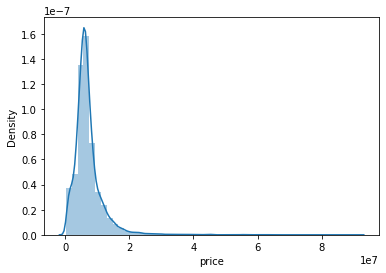

In [44]:
sns.distplot(y_train); # длинный хвост

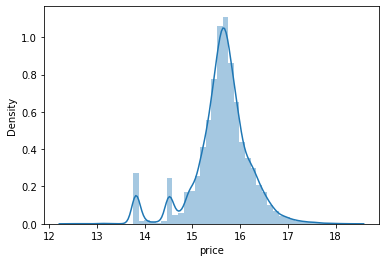

In [45]:
sns.distplot(np.log(y_train));

In [46]:
y_test_norm = np.log(y_test)
y_train_norm = np.log(y_train)

In [47]:
print(y_train_norm.max())

18.327096130501715


In [48]:
#  значение моделей на нормализованных данных:
lin_reg = LinearRegression()
lin_reg.fit(X_train_norm, y_train)
y_pred = lin_reg.predict(X_test_norm)
print(f'Линейная регрессия на нормализованных данных: {RMSE(y_test, y_pred)}') # значение немного ухудшилось

Линейная регрессия на нормализованных данных: 3229498.2876013517


In [49]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(X_train_norm, y_train)
y_pred = clf.predict(X_test_norm)
print(f'Дерево решений на нормализованных данных: {RMSE(y_test, y_pred)}') # значение ухудшилось, значит нормализуя данные - мы теряем информацию

Дерево решений на нормализованных данных: 3919655.0854102164


### Отбор признаков с помощью L1 регуляризации

In [50]:
history = []
cs = np.linspace(0.001, 1200, 7)
for c in tqdm(cs):
    log_reg = Lasso(alpha=c)
    log_reg.fit(X_train_norm, y_train)
    y_pred = log_reg.predict(X_test_norm)
    history.append(mean_squared_error(y_test, y_pred, squared=False))

100%|██████████| 7/7 [01:53<00:00, 16.26s/it]


Text(0, 0.5, 'RMSE')

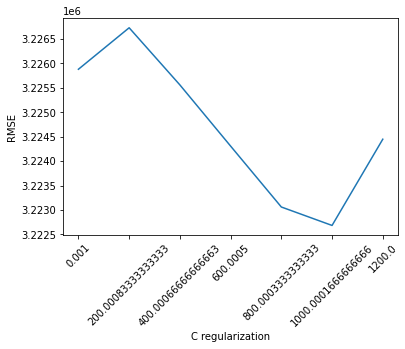

In [51]:
plt.plot(np.arange(len(history)), history)
plt.xticks(np.arange(len(history)), cs, rotation=45)
plt.xlabel('C regularization')
plt.ylabel('RMSE')

In [52]:
idx = np.argmin(history)
print(f'лучший скор: {history[idx]}')
print(f'C = {cs[idx]}')

лучший скор: 3222683.3005640176
C = 1000.0001666666666


In [53]:
c = cs[idx]
lin_reg = Lasso(alpha=c)
lin_reg.fit(X_train_norm, y_train)

Lasso(alpha=1000.0001666666666)

In [54]:
coefs = lin_reg.coef_

In [55]:
print(sorted(coefs, key=lambda x: abs(x))) # видим что L1 регуляризация занулила огромное кол-во коеффициентов

[0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 3.248979333650869e-11, -5.38820898674537e-11, 5.665688113831023e-11, -1.7729822477560606e-10, 3.4505070250776887e-10, 4.60040957146179e-10, 4.422

In [56]:
coefs_pd = pd.DataFrame({'w' : coefs, 'abs_w' : np.abs(coefs)}) # отсортируем коэффициенты по возрастанию их модуля
coefs_pd.sort_values(by=['abs_w'])

,w,abs_w
450,-0.000000e+00,0.000000e+00
233,0.000000e+00,0.000000e+00
413,0.000000e+00,0.000000e+00
412,0.000000e+00,0.000000e+00
411,-0.000000e+00,0.000000e+00
...,...,...
358,1.922964e+06,1.922964e+06
188,-2.057986e+06,2.057986e+06
310,2.792029e+06,2.792029e+06
339,-2.960148e+06,2.960148e+06


In [57]:
print(len(coefs_pd[coefs_pd['abs_w'] < 1])) # ненужные признаки

165


In [58]:
idxs = coefs_pd[coefs_pd['abs_w'] < 1].index

In [59]:
bad_columns = X_train.columns[idxs]
X_train_r = X_train.drop(columns=bad_columns) # reduced X_train
X_test_r = X_test.drop(columns = bad_columns)

In [60]:
print(X_train_r.shape)
print(X_test_r.shape)

(16000, 286)
(4000, 286)


In [61]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_r, y_train)
y_pred = lin_reg.predict(X_test_r)
print(f'Линеная регрессия: с отбором признаков {RMSE(y_test, y_pred)}')

Линеная регрессия: с отбором признаков 3232438.1395197045


In [62]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(X_train_r, y_train)
y_pred = clf.predict(X_test_r)
print(f'Дерево решений c отбором признаков: {RMSE(y_test, y_pred)}')

Дерево решений c отбором признаков: 3755930.01382082


Проверьте качество на отложенной выборке.

### Подберем признаки для решающего дерева

In [63]:
depths = np.linspace(50, 400, 25, dtype=int)
hist1 = []
for d in tqdm(depths): # подбор параметра max_depth
    clf = DecisionTreeRegressor(max_depth=d)
    clf.fit(X_train_r, y_train)
    y_pred = clf.predict(X_test_r)
    hist1.append(RMSE(y_test, y_pred))

100%|██████████| 25/25 [01:09<00:00,  2.78s/it]


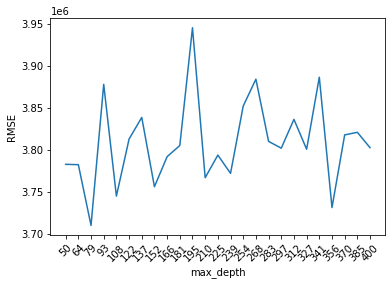

In [64]:
plt.plot(np.arange(len(hist1)), hist1)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.xticks(np.arange(len(hist1)), depths, rotation=45);

In [65]:
idx = 5
print(hist1[idx])
print(depths[idx])

3813002.3975572465
122


In [66]:
leafs = np.linspace(10, 100, 20, dtype=int)
hist2 = []
for leaf in tqdm(leafs): # подбор параметра min_samples_leaf
    clf = DecisionTreeRegressor(min_samples_leaf=leaf)
    clf.fit(X_train_r, y_train)
    y_pred = clf.predict(X_test_r)
    hist2.append(RMSE(y_test, y_pred))

100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


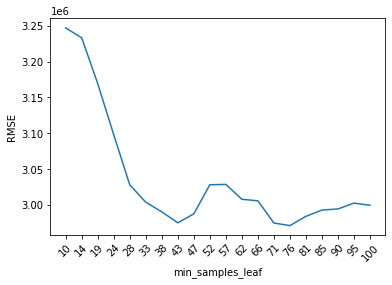

In [67]:
plt.plot(np.arange(len(leafs)), hist2)
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.xticks(np.arange(len(hist2)), leafs, rotation=45);

In [68]:
idx = np.argmin(hist2)
print(hist2[idx])
print(leafs[idx])

2971821.3080791165
76


In [69]:
clf = DecisionTreeRegressor(max_depth=79, min_samples_leaf=76)
clf.fit(X_train_r, y_train)
y_pred = clf.predict(X_test_r)
print(RMSE(y_test, y_pred))

2971821.3080791165


### Feature Engineering (2 балла)

Часто улучшить модель можно с помощью аккуратного Feature Engineering.

Добавим в модель дополнительные признаки:
* "Как часто в этот год и этот месяц появлились объявления"
* "Как часто в этот год и эту неделю появлялись объявления"

In [70]:
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100) # хешируем год + месяц
month_year_cnt_map = month_year.value_counts().to_dict()
df["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df["week_year_cnt"] = week_year.map(week_year_cnt_map)

Добавьте следюущие дополнительные признаки:
* Месяц (из колонки `timestamp`)
* День недели (из колонки `timestamp`)
* Отношение "этаж / максимальный этаж в здании" (колонки `floor` и `max_floor`)
* Отношение "площадь кухни / площадь квартиры" (колонки `kitch_sq` и `full_sq`)

По желанию можно добавить и другие признаки.

In [71]:
df['month'] = df.timestamp.dt.month
df['weekday'] = df.timestamp.dt.weekday
df['height%'] = df['floor'] / df['max_floor']
df['kitchen%'] = df['kitch_sq'] / df['full_sq']

In [72]:
feature_cols = ['month_year_cnt', 'week_year_cnt', 'month', 'weekday', 'height%', 'kitchen%']
df[feature_cols].isna().sum()

month_year_cnt       0
week_year_cnt        0
month                0
weekday              0
height%           6305
kitchen%          6304
dtype: int64

In [73]:
X_train_r.index

Int64Index([ 5894,  3728,  8958,  7671,  5999,  5751,  1688,  6836,  6536,
             4842,
            ...
            11363, 14423,  4426, 16850,  6265, 11284, 11964,  5390,   860,
            15795],
           dtype='int64', length=16000)

Разделите выборку на обучающую и тестовую еще раз (потому что дополнительные признаки созданы для исходной выборки).

In [74]:
eps = 1e-5

In [75]:
X_train_r['max_floor'] += eps # чтобы не делить на нули
X_train_r['full_sq'] += eps
X_test_r['max_floor'] += eps
X_test_r['full_sq'] += eps

In [76]:
X_train_r['height%'] = np.clip(X_train_r['floor'] / X_train_r['max_floor'], 0, 1) # преобразуем трейн и тест отдельно, чтобы не было мемори ликов
X_train_r['kitchen%'] = np.clip(X_train_r['kitch_sq'] / X_train_r['full_sq'], 0, 1)
X_train_r['month'] = df.loc[X_train_r.index]['month']
X_train_r['weekday'] = df.loc[X_train_r.index]['weekday']

X_test_r['height%'] = np.clip(X_test_r['floor'] / X_test_r['max_floor'], 0, 1)
X_test_r['kitchen%'] = np.clip(X_test_r['kitch_sq'] / X_test_r['full_sq'], 0, 1)
X_test_r['month'] = df.loc[X_test_r.index]['month']
X_test_r['weekday'] = df.loc[X_test_r.index]['weekday']

### Model Selection (3 балла)

Посмотрите, какого качества можно добиться если использовать разные модели:
* `DecisionTreeRegressor` из `sklearn`
* `RandomForestRegressor` из `sklearn`
* `CatBoostRegressor`

Также вы можете попробовать линейные модели, другие бустинги (`LigthGBM` и `XGBoost`).

Почти все библиотеки поддерживают удобный способ подбора гиперпараметров: посмотрите как это делать в [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) или в [catboost](https://catboost.ai/docs/concepts/python-reference_catboostregressor_grid_search.html).

Проверяйте качество каждой модели на тестовой выборке и выберите наилучшую.

In [77]:
lin_reg = LinearRegression() # Линейная регрессия
lin_reg.fit(X_train_r, y_train)
y_pred = lin_reg.predict(X_test_r)
print(f'Линеная регрессия: с отбором признаков и feature инжинирингом {RMSE(y_test, y_pred)}') # стало чуть лучше

Линеная регрессия: с отбором признаков и feature инжинирингом 3229098.0433697538


In [78]:
clf = DecisionTreeRegressor(min_samples_leaf=76) # Дерево решений
clf.fit(X_train_r, y_train)
y_pred = clf.predict(X_test_r)
print(f'Дерево решений c отбором признаков и feature инжинирингом: {RMSE(y_test, y_pred)}')

Дерево решений c отбором признаков и feature инжинирингом: 2976903.9330579336


In [79]:
clf = RandomForestRegressor(n_estimators=100, max_features = X_train.shape[1]//3, max_samples=0.5)
clf.fit(X_train_r, y_train)
y_pred = clf.predict(X_test_r)
print(f' Случайный лес с отбором признаков и feature инжиннирингом: {RMSE(y_test, y_pred)}')

 Случайный лес с отбором признаков и feature инжиннирингом: 2622298.2445838535


In [82]:
cat = CatBoostRegressor(verbose=0, n_estimators = 500)
cat.fit(X_train_r, y_train)
y_pred = cat.predict(X_test_r)
print(f'Градиентный бустинг с отбором признаков и feature инжиннирингом: {RMSE(y_test, y_pred)}')

Градиентный бустинг с отбором признаков и feature инжиннирингом: 2528349.0040742285


In [86]:
xgb = xgboost.XGBRegressor(n_estimators = 500, objective ='reg:squarederror')
xgb.fit(X_train_r, y_train)
y_pred = xgb.predict(X_test_r)
print(f'Другой градиентный бустинг с отбором признаков и feature инжиннирингом: {RMSE(y_test, y_pred)}')

Другой градиентный бустинг с отбором признаков и feature инжиннирингом: 2659004.717902067


In [96]:
lgbm = lightgbm.LGBMRegressor(n_estimators=500)
lgbm.fit(X_train_r, y_train)
y_pred = lgbm.predict(X_test_r)
print(f'lightGBM градиентный бустинг с отбором признаков и feature инжиннирингом: {RMSE(y_test, y_pred)}')

lightGBM градиентный бустинг с отбором признаков и feature инжиннирингом: 2601250.7611257746


### Ensemble v.1 (3 балла)

Ансамбли иногда оказываются лучше чем одна большая модель.

В колонке `product_type` содержится информация о том, каким является объявление: `Investment` (продажа квартиры как инвестиции) или `OwnerOccupier` (продажа квартиры для жилья). Логично предположить, что если сделать по модели на каждый из этих типов, то качество будет выше.

Обучите свои лучшие модели на отдельно на `Investment` и `OwnerOccupier` (т.е. у вас будет `model_invest`, обученная на `(invest_train_X, invest_train_Y)` и `model_owner`, обученная на `(owner_train_X, owner_train_Y)`) и проверьте качество на отложенной выборке (т.е. на исходном `test_split`).

In [102]:
mask = np.char.startswith(list(X_train_r.columns),'product_type')
print(X_train_r.columns[mask])

Index(['product_type_Investment'], dtype='object')


In [124]:
X_train_inv = X_train_r[X_train_r['product_type_Investment'] == 1] # разделение всех выборок
y_train_inv = y_train.loc[X_train_inv.index]
X_train_own = X_train_r[X_train_r['product_type_Investment'] == 0]
y_train_own = y_train.loc[X_train_own.index]

X_test_inv = X_test_r[X_test_r['product_type_Investment'] == 1]
X_test_own = X_test_r[X_test_r['product_type_Investment'] == 0]

In [125]:
cat_inv = CatBoostRegressor(verbose=0, n_estimators = 500) # оубучение моделей
cat_inv.fit(X_train_inv, y_train_inv)
cat_own = CatBoostRegressor(verbose=0, n_estimators = 500)
cat_own.fit(X_train_own, y_train_own)

In [136]:
y_inv_idxs = np.where(X_test_r['product_type_Investment'] == 1) # индексы
y_own_idxs = np.where(X_test_r['product_type_Investment'] == 0)

In [137]:
y_inv = cat_inv.predict(X_test_inv)  # ответы для индексов
y_own = cat_own.predict(X_test_own)

In [142]:
y_pred = np.zeros_like(y_test) # единый массив ответов
y_pred[y_inv_idxs] = y_inv
y_pred[y_own_idxs] = y_own

In [143]:
print(f'Ансамбль из двух catboost для разных типов жилья RMSE = {RMSE(y_test, y_pred)}')

Ансамбль из двух catboost для разных типов жилья RMSE = 2491412.515572773


In [148]:
print(f'средняя абсолютная ошибка: {mean_absolute_error(y_test, y_pred)}')
print(f'средняя цена: {np.mean(y_test)}')

средняя абсолютная ошибка: 1392836.81275
средняя цена: 7140915.0145


### (*) Ensemble v.2 (дополнительно, 2 балла)

Попробуйте сделать для `Investment` более сложную модель: обучите `CatBoostRegressor` и `HuberRegressor` из `sklearn`, а затем сложите их предсказания с весами `w_1` и `w_2` (выберите веса сами; сумма весов равняется 1).

In [153]:
y_inv_test = np.array(y_test)[y_inv_idxs] # истинные ответы для двух типов жилья
y_own_test = np.array(y_test)[y_own_idxs]

In [154]:
print(f'Investment предсказания RMSE = {RMSE(y_inv_test, y_inv)}')
print(f'Owner предсказания RMSE = {RMSE(y_own_test, y_own)}')

Investment предсказания RMSE = 2986175.0463391463
Owner предсказания RMSE = 1091165.1002023178


In [157]:
cat = CatBoostRegressor(n_estimators=500, verbose=0)
cat.fit(X_train_inv, y_train_inv)
y_inv_cat = cat.predict(X_test_inv)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [170]:
hub_reg = HuberRegressor()
hub_reg.fit(X_train_inv, y_train_inv)
y_inv_hub = hub_reg.predict(X_test_inv)

In [171]:
print(RMSE(y_inv_test, y_inv_hub))

4865521.848348602


In [178]:
ws = np.linspace(0, 1, 100)
h = []
for w in tqdm(ws):
    y_pred = y_inv_cat * w + y_inv_hub * (1 - w)
    h.append(RMSE(y_inv_test, y_pred))

100%|██████████| 100/100 [00:00<00:00, 1673.12it/s]


Text(0, 0.5, 'RMSE')

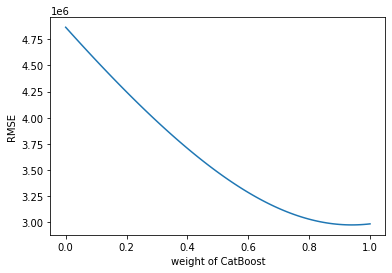

In [182]:
plt.plot(ws, h)
plt.xlabel('weight of CatBoost')
plt.ylabel('RMSE')

Более сложная модель, не стала лучше, чем просто catboost

### Выводы:
Лучший скор дал ансамбль из двух catboost отдельно для двух типов объявлений: 
`Investment` и `OwnerOccupier`. Также мы произвели отбор признаков с помощью L1 линейной регрессии, очистили данные от пропусков с помощью техники KFold, и покрафтили фичи.

**Итоговый RMSE = 2491412.5**